# DTSA 5510 Unsupervised Algorithms in Machine Learning - Final Project

Github: https://github.com/tkdev001/yahoo_news_jp_classification

## 1. Introduction

The motivation of this project is to apply machine learning techniques to classify topics for Japanese news articles. For unsupervised algorithms, **k-means clustering**, **hierarchical clustering**, and **non-negative matrix factorization** (NMF) will be used. **Random forest** will also be used for comparison.

Major tasks of this project including:

*   Data collection
*   Exploratory data analysis
*   Data pre-processing
*   Model fitting, evaluation, analysis

### Prerequisite installation

In [ ]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3
!pip install mojimoji

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget4 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl liburi-perl libxapian30 swig4.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget4 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-me

In [ ]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!./mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a -y

!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), 58.09 MiB | 8.81 MiB/s, done.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-me

In [ ]:
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd


In [ ]:
!wget http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

--2023-02-28 04:20:01--  http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt
Resolving svn.sourceforge.jp (svn.sourceforge.jp)... 44.240.209.230
Connecting to svn.sourceforge.jp (svn.sourceforge.jp)|44.240.209.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2202 (2.2K) [text/plain]
Saving to: ‘Japanese.txt’

Japanese.txt        100%[===================>]   2.15K  --.-KB/s    in 0s      

2023-02-28 04:20:01 (228 MB/s) - ‘Japanese.txt’ saved [2202/2202]



## 2. Data collection

News articles have been scraped from Yahoo! News Japan (https://news.yahoo.co.jp) in late Feb (19th, 23rd-25th) 2023. Technical detail of the web scraping procedure will not be included in this notebook.

The dataset contains below fields:

*   `title`
*   `url`
*   `content`
*   `category`



`content` contains the article of each news and will be used as feature. `category` will be used to verify the result (and label for random forest). `title` and `url` will not be used in this project.

Although all the news articles are written in Japanese, readers of this notebook are not expected to have prior knowledge in Japanese.

### 1. Import file

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import itertools
import MeCab
import mojimoji

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering

In [ ]:
file_path = "/content/drive/MyDrive/raw/yahoo_news/yahoo_news_202302.json"

with open(file_path, encoding="utf-8") as f:
  lines = f.read().splitlines()

news_df_inter = pd.DataFrame(lines, columns=["json_element"])
news_df = pd.json_normalize(news_df_inter["json_element"].apply(json.loads)).drop(["title", "url"], axis="columns")

news_df.head()

,content,category
0,同点弾のウッド プレミアリーグ第24節でノッティンガム・フォレストはマンチェスター・シティと...,sports
1,ブルペン投球を行った佐々木朗希【写真：小林靖】野球日本代表「侍ジャパン」の宮崎合宿は19日、...,sports
2,U20選抜競歩に優勝した大山藍2月19日、兵庫県神戸市の六甲アイランドで第34回U20選抜競...,sports
3,イメージ画像2月19日、小倉競馬場で行われた小倉大賞典はムルザバエフ騎手騎乗のヒンドゥタイム...,sports
4,山本の投球を見ながら話し込む佐々木朗とダルビッシュ（撮影・金田祐二）「侍ジャパン強化合宿」（...,sports


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7612 entries, 0 to 7611
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   7612 non-null   object
 1   category  7612 non-null   object
dtypes: object(2)
memory usage: 119.1+ KB


### 2. Remove duplicates

In [ ]:
news_df.drop_duplicates(subset="content", inplace=True)
news_df.reset_index(drop=True, inplace=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6617 entries, 0 to 6616
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   6617 non-null   object
 1   category  6617 non-null   object
dtypes: object(2)
memory usage: 103.5+ KB


## 3. Exploratory data analysis

### 1. Category distribution

[Text(0, 0, '1287'),
 Text(0, 0, '1380'),
 Text(0, 0, '1203'),
 Text(0, 0, '827'),
 Text(0, 0, '950'),
 Text(0, 0, '970')]

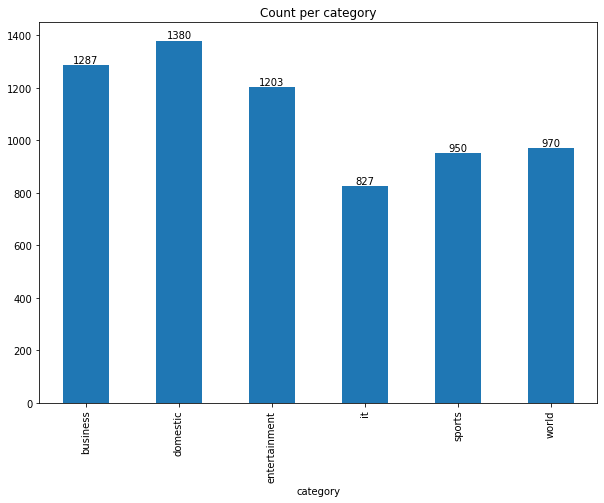

In [ ]:
ax = news_df.groupby("category")["category"].count().plot(kind="bar", 
                                                          title="Count per category", 
                                                          figsize=(10, 7))
ax.bar_label(ax.containers[0])

### 2. Word count distribution

<AxesSubplot:>

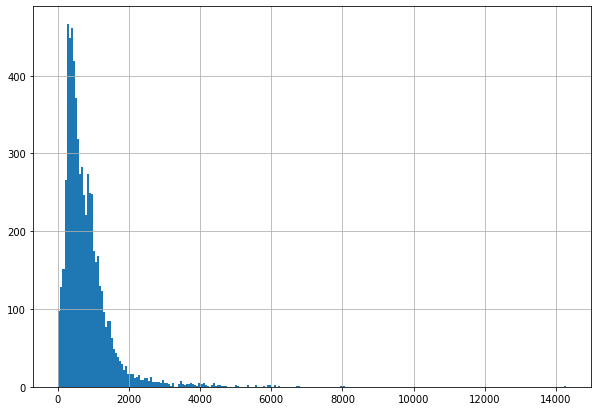

In [ ]:
news_df["content"].str.len().hist(bins=250, figsize=(10, 7))

After cleaning up, the dataset contains a total of 6617 news articles in 6 categories. Each category consists of 827-1380 articles. Most of the articles are under 2000 words in length.

## 3. Data pre-processing

### 1. Tokenization

Unlike English which could be splitted by space, there is not a quick way to tokenize Japanese sentences. There are many libraries that can be used to perform the task. Each of them uses a different approach and none of them is perfect. In this project, below tools will be used to tokenize and clean up the articles:


*   `MeCab` library with `mecab-ipadic-NEologd` dictionary file to tokenize and lemmatize articles
*   `mojimoji` library to convert full-width letters and digits to half-width
*   Remove stopwords by utilizing the stopword list provided by SlothLib


In [ ]:
with open("/content/Japanese.txt","r") as f:
  stopwords = f.read().split("\n")

dict_path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
mecab = MeCab.Tagger(dict_path)

def mecab_tokenizer(text, mecab=mecab, stopwords=stopwords):
  replaced_text = text.lower()
  
  # Remove numbers
  replaced_text = re.sub(r"\d+\.*\d*", "", replaced_text)
  
  # Convert full-width letters and digits to half-width
  replaced_text = mojimoji.zen_to_han(replaced_text, kana=False, digit=True, ascii=True)

  parsed_lines = mecab.parse(replaced_text).split("\n")[:-2]
  token_list_tmp = [[l.split("\t")[0], l.split("\t")[1].split(",")[6]] for l in parsed_lines]
  token_list = [e[1] if e[1] != "*" else e[0] for e in token_list_tmp]
  
  # Parts of speech
  pos = [l.split("\t")[1].split(",")[0] for l in parsed_lines]
  target_pos = ["名詞", "動詞", "形容詞"] # Only include noun, verb, adjective
  token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
  
  # Remove stopwords & date/time indicators
  datetime_words = ["年月日", "年月", "月日", "時分", "午前", "午後"]
  token_list = [t for t in token_list if ((t not in stopwords) and (t not in datetime_words))]

  # Remove hiragana-only phases
  kana_re = re.compile("^[ぁ-ゖ]+$")
  token_list = [t for t in token_list if not kana_re.match(t)]
  
  return " ".join(token_list)

In [ ]:
news_df["clean_text"] = news_df["content"].apply(mecab_tokenizer)
news_df.head()

,content,category,clean_text
0,同点弾のウッド プレミアリーグ第24節でノッティンガム・フォレストはマンチェスター・シティと...,sports,同点弾 ウッド Premier League 節 ノッティンガム・フォレスト マンチェスター...
1,ブルペン投球を行った佐々木朗希【写真：小林靖】野球日本代表「侍ジャパン」の宮崎合宿は19日、...,sports,ブルペン投球 行う 佐々木朗希 写真 小林 靖 野球日本代表 侍ジャパン 宮崎 合宿 クール...
2,U20選抜競歩に優勝した大山藍2月19日、兵庫県神戸市の六甲アイランドで第34回U20選抜競...,sports,u 選抜 競歩 優勝 大山藍 兵庫県神戸市 六甲アイランド u 選抜 競歩 行う 女子 km...
3,イメージ画像2月19日、小倉競馬場で行われた小倉大賞典はムルザバエフ騎手騎乗のヒンドゥタイム...,sports,イメージ 画像 小倉競馬場 行う 小倉大賞典 ムルザバエフ 騎手 騎乗 ヒンドゥ・タイムズ ...
4,山本の投球を見ながら話し込む佐々木朗とダルビッシュ（撮影・金田祐二）「侍ジャパン強化合宿」（...,sports,山本 投球 見る 話し込む 佐々木 朗 ダルビッシュ 撮影 金田 祐二 侍ジャパン 強化合宿...


### 2. Split dataset

Split the dataset into training set and testing set with a 7:3 ratio.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(news_df["clean_text"], 
                                                    news_df["category"], 
                                                    test_size=0.3, random_state=100)

In [ ]:
print(len(train_x))
print(len(test_x))

4631
1986


### 3. Word embedding

TF-IDF will be used to vectorize the articles. TF-IDF stands for "Term Frequency-Inverse Document Frequency." It is a statistical method used to evaluate the importance of a word in a document within a collection of documents. The term frequency (TF) measures the number of times a word appears in a document, while the inverse document frequency (IDF) measures how often a word appears in the entire collection of documents. The final TF-IDF score is the product of these two values, providing a measure of the importance of a word in a document relative to the entire collection.

The idea behind TF-IDF is that words that occur frequently in a document are important, but common words across many documents are not as significant. For example, the word "the" may appear frequently in many documents, but its high frequency across the entire collection of documents makes it less important in determining the uniqueness of a single document. On the other hand, a word that appears frequently in a single document and less often in the rest of the collection would be considered more important in determining the content of that document.

In [ ]:
tfidvec = TfidfVectorizer(min_df = 5, max_df = 0.9)
tfidvec_train = tfidvec.fit_transform(train_x)
tfidvec_train.shape

(4631, 13447)

In [ ]:
tfidvec_test = tfidvec.transform(test_x)
tfidvec_test.shape

(1986, 13447)

## 4. Model fitting

### 0. Utility function

In [ ]:
labels = ("domestic", "world", "business", "entertainment", "sports", "it")

In [ ]:
def label_permute(y_true, y_predicted, labels):
  n = len(labels)
  best_labels = None
  best_acc = 0

  for perm in itertools.permutations(range(n)):
      acc = accuracy_score(pd.DataFrame(y_true),
                           pd.DataFrame(y_predicted).replace(perm, labels))
      if acc > best_acc:
          best_labels = perm
          best_acc = acc

  return best_labels, best_acc

### 1. Mini-Batch K-Means clustering

#### 1. Model ftting

In [ ]:
km = MiniBatchKMeans(n_clusters=len(labels), random_state=100).fit(tfidvec_train)
predicted_train_km = km.predict(tfidvec_train)
label_order_km, acc_train_km = label_permute(train_y, predicted_train_km, labels)
print(f"Label order = {label_order_km}")
print(f"Training accuracy = {acc_train_km}")

Label order = (5, 3, 0, 1, 4, 2)
Training accuracy = 0.4592960483696826


#### 2. Attempt to improve performance with PCA

As k-means clustering suffers from the curse of dimensionality, let's reduce the dimension of the input matrix and see if it helps.

In [ ]:
pca = PCA(n_components = 0.9, svd_solver = "full").fit(tfidvec_train.toarray())
tfidvec_train_pca = pca.transform(tfidvec_train.toarray())
tfidvec_train_pca.shape

(4631, 2550)

In [ ]:
km_pca = MiniBatchKMeans(n_clusters=len(labels), random_state=100).fit(tfidvec_train_pca)
predicted_train_km_pca = km_pca.predict(tfidvec_train_pca)
label_order_km_pca, acc_train_km_pca = label_permute(train_y, predicted_train_km_pca, labels)
print(f"Label order = {label_order_km_pca}")
print(f"Training accuracy = {acc_train_km_pca}")

Label order = (1, 2, 3, 4, 0, 5)
Training accuracy = 0.4009933059814295


With `n_components=0.9`, PCA reduced the number of features from 13447 to 2550. But training accuracy is lowered by around 6% when fitting with the reduced matrix.

#### 3. Validation with test set

In [ ]:
predicted_test_km = pd.DataFrame(km.predict(tfidvec_test)).replace(label_order_km, labels)
print(f"Testing accuracy = {accuracy_score(test_y, predicted_test_km)}")

Testing accuracy = 0.4511581067472306


In [ ]:
tfidvec_test_pca = pca.transform(tfidvec_test.toarray())
tfidvec_test_pca.shape

(1986, 2550)

In [ ]:
# With PCA
predicted_test_km_pca = pd.DataFrame(km_pca.predict(tfidvec_test_pca)).replace(label_order_km_pca, labels)
print(f"Testing accuracy = {accuracy_score(test_y, predicted_test_km_pca)}")

Testing accuracy = 0.41037260825780464


### 2. Hierarchical clustering

#### 1. Model ftting

In [ ]:
predicted_train_hc = AgglomerativeClustering(n_clusters=len(labels), 
                                             affinity="cosine", linkage="average").fit_predict(tfidvec_train.toarray())
label_order_hc, acc_train_hc = label_permute(train_y, predicted_train_hc, labels)
print(f"Label order = {label_order_hc}")
print(f"Training accuracy = {acc_train_hc}")

Label order = (1, 4, 0, 2, 5, 3)
Training accuracy = 0.3815590585186785


#### 2. Attempt to improve performance with PCA

Similar to k-means clustering, hierarchical clustering also suffers from the curse of dimensionality. Let's see if PCA helps.

In [ ]:
predicted_train_hc_pca = AgglomerativeClustering(n_clusters=len(labels), 
                                                 affinity="cosine", linkage="average").fit_predict(tfidvec_train_pca)
label_order_hc_pca, acc_train_hc_pca = label_permute(train_y, predicted_train_hc_pca, labels)
print(f"Label order = {label_order_hc_pca}")
print(f"Training accuracy = {acc_train_hc_pca}")

Label order = (3, 1, 4, 5, 2, 0)
Training accuracy = 0.5884258259555172


With PCA, the accuracy increased significantly. But still it is not very satisfying.

Validation with test set will not be done for hierarchical clustering. As the model does not partition the input space, we cannot apply the trained model on a new set of data.

### 3. NMF

#### 1. Model fitting

In [ ]:
nmf = NMF(n_components=len(labels), random_state=100)
predicted_train_nmf = np.argmax(nmf.fit_transform(tfidvec_train), axis=1)
label_order_nmf, acc_train_nmf = label_permute(train_y, predicted_train_nmf, labels)
print(f"Label order = {label_order_nmf}")
print(f"Training accuracy = {acc_train_nmf}")

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Label order = (3, 0, 2, 1, 4, 5)
Training accuracy = 0.5696393867415245


#### 2. Hyperparameter tuning

After trying with different combinations of `init`, `solver`, and `beta_loss`, below setting gives the highest accuracy.

In [ ]:
nmf = NMF(n_components=len(labels),
          init="nndsvda",
          solver="mu",
          beta_loss="kullback-leibler",
          random_state=100)
predicted_train_nmf = np.argmax(nmf.fit_transform(tfidvec_train), axis=1)
label_order_nmf, acc_train_nmf = label_permute(train_y, predicted_train_nmf, labels)
print(f"Label order = {label_order_nmf}")
print(f"Training accuracy = {acc_train_nmf}")

Label order = (3, 0, 2, 1, 4, 5)
Training accuracy = 0.6806305333621248


#### 3. Validation with test set

In [ ]:
predicted_test_nmf = pd.DataFrame(np.argmax(nmf.transform(tfidvec_test), axis=1)).replace(label_order_nmf, labels)
print(f"Testing accuracy = {accuracy_score(test_y, predicted_test_nmf)}")

Testing accuracy = 0.6576032225579054


NMF gives the highest accuracy among the models (although the result is not very satisfying).

### 4. Random forest

As a reference, let's fit a random forest model and see how it performs.

In [ ]:
rf_clf = RandomForestClassifier(random_state=100)
rf_clf.fit(tfidvec_train, train_y)
print(f"Training accuracy = {accuracy_score(train_y, rf_clf.predict(tfidvec_train))}")
print(f"Testing accuracy = {accuracy_score(test_y, rf_clf.predict(tfidvec_test))}")

Training accuracy = 1.0
Testing accuracy = 0.8041289023162135


The accuracy is higher than all the above unsupervised models.

## 5. Analysis and discussion

Among the unsupervised models being applied, NMF performs the best. In this section, I will analyze and discuss about the result based on the NMF model.

### 1. Accuracy per category

[Text(0, 0, '0.444322'),
 Text(0, 0, '0.454171'),
 Text(0, 0, '0.88172'),
 Text(0, 0, '0.815068'),
 Text(0, 0, '0.932749'),
 Text(0, 0, '0.703704')]

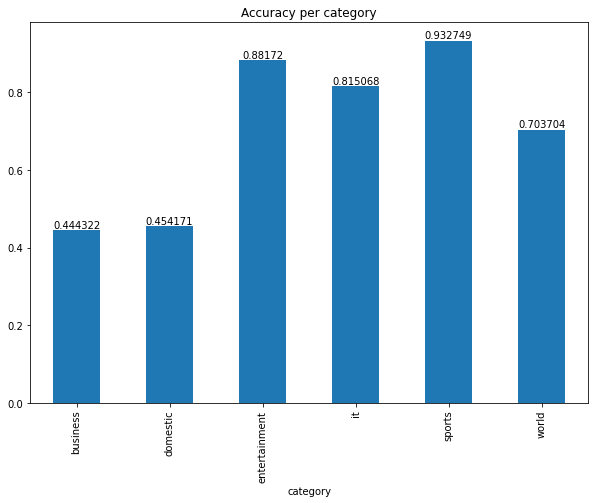

In [ ]:
df_train = pd.DataFrame(train_x, columns=["clean_text"])
df_train["category"] = train_y
df_train["predicted_i"] = predicted_train_nmf
df_train["predicted"] = df_train["predicted_i"].replace(label_order_nmf, labels)

count = df_train.groupby("category")["category"].count()
acc =  df_train[df_train["category"] == df_train["predicted"]].groupby("category")["category"].count()

ax = (acc/count).plot(kind="bar", title="Accuracy per category", figsize=(10, 7))
ax.bar_label(ax.containers[0])

Accuracy of domestic and business news is the lowest among the categories. Let's see the categories which they were being misclassified to.

<AxesSubplot:title={'center':'Domestic misclassified as'}, xlabel='predicted'>

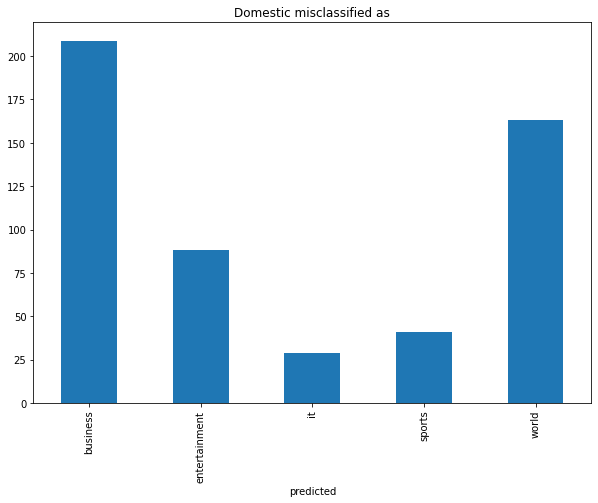

In [ ]:
wrong = df_train[df_train["category"] != df_train["predicted"]]
wrong[wrong["category"] == "domestic"].groupby("predicted")["predicted"].count().plot(kind="bar", 
                                                                                      title="Domestic misclassified as",
                                                                                      figsize=(10, 7))

<AxesSubplot:title={'center':'Business misclassified as'}, xlabel='predicted'>

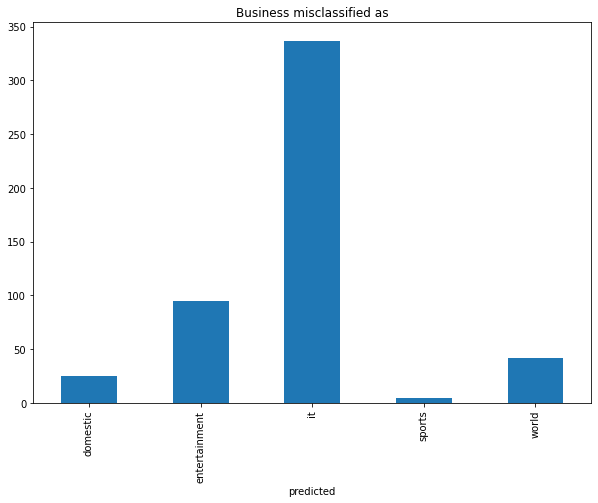

In [ ]:
wrong[wrong["category"] == "business"].groupby("predicted")["predicted"].count().plot(kind="bar", 
                                                                                      title="Business misclassified as", 
                                                                                      figsize=(10, 7))

### 2. Popular keywords of each category

In [ ]:
components_df = pd.DataFrame(nmf.components_, columns=tfidvec.get_feature_names())
for topic in range(components_df.shape[0]):
  tmp = components_df.iloc[topic]
  print(f"{labels[label_order_nmf.index(topic)]}:")
  print(tmp.nlargest(10))
  print("\n")

world:
ウクライナ    1.579518
ロシア      1.375286
中国       0.659174
侵攻       0.623130
戦争       0.446035
支援       0.373753
日本       0.336134
大統領      0.331603
米国       0.304519
北朝鮮      0.303627
Name: 0, dtype: float64


entertainment:
思う           0.505253
出演           0.319694
instagram    0.302822
作品           0.293889
言う           0.279575
公開           0.269141
見る           0.268199
放送           0.260066
映画           0.240969
投稿           0.238162
Name: 1, dtype: float64


business:
上昇     0.341787
総裁     0.338895
企業     0.304468
ドル     0.282347
日銀     0.255262
候補     0.251879
政府     0.249363
述べる    0.234457
必要     0.229205
示す     0.227927
Name: 2, dtype: float64


domestic:
容疑者    0.616875
逮捕     0.476531
男性     0.460641
警察     0.377686
事件     0.377387
疑い     0.353498
容疑     0.335808
女性     0.325411
死亡     0.323637
警視庁    0.307086
Name: 3, dtype: float64


sports:
試合       0.639727
選手       0.589457
投手       0.404277
チーム      0.398563
思う       0.325689
出場       0.324579
侍ジャパン    0.296915


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


| Domestic |  | Business |  | World |  |
| :- | :- | :- | :- | :- | :- |
| 容疑者 | suspect | 上昇 | raise | ウクライナ | Ukraine
| 逮捕 | arrest | 総裁 | president (of an organization) | ロシア | Russia
| 男性 | male | 企業 | corporation | 中国 | China
| 警察 | police | ドル | dollar | 侵攻 | invasion
| 事件 | case | 日銀 | Bank of Japan | 戦争 | war
| 疑い | suspicion | 候補 | candidate | 支援 | support
| 容疑 | suspicion | 政府 | government | 日本 | Japan
| 女性 | female | 述べる | state | 大統領 | President (of a country)
| 死亡 | death | 必要 | necessarily | 米国 | America
| 警視庁 | Metropolitan Police Department | 示す | demonstrate | 北朝鮮 | North Korea



| Entertainment |  | Sports |  | IT |  |
| :- | :- | :- | :- | :- | :- |
| 思う | think | 試合 | match | 機能 | function
| 出演 | perform | 選手 | player | モデル | model
| instagram |  | 投手 | pitcher | ai | 
| 作品 | a (piece of) work | チーム | team | 利用 | application
| 言う | speak | 思う | think | 販売 | selling
| 公開 | release | 出場 | entry | 可能 | able
| 見る | look/see/watch | 侍ジャパン | Samurai Japan | mm | 
| 放送 | broadcast | 優勝 | victory | 発売 | sale
| 映画 | movie | 大会 | tournament | 搭載 | installation
| 投稿 | a contribution | 勝利 | victory | 開発 | development


### 3. Discussion and potential ways for improvement

1. Among the unsupervised models being applied, NMF performs the best. One of the reasons could be the curse of dimensionality, which affects distance based algorithms like k-means clustering and hierarchical clustering. 

2. From the categorical breakdown of accuracy, the model has problem of misclassifying domestic news as business/world news, and business news as IT news. One of the reasons is because of the nature of the dataset - for some of the news, it is natural to classify them into both categories. For example, news about monetary policy can be classified as both domestic news and business news. 

3. From the top keyword list, there may be data imbalance in some categories in the raw dataset. For example, many of the keywords in the domestic category are related to criminal cases, which is not very ideal given the large variety of domestic news. Data imbalance is one of the reasons for higher performance of random forest, as tree-based algorithms often perform better on imbalanced datasets. Collecting data across a longer period and resampling can potentially help.

4. There are many ways to perform word embedding. TF-IDF is a relatively simple method. It only consider the frequency of individual word, without accounting for the relationships between the words nearby. Using more advianced methods like word2vec and BERT may provide a better result.

5. More time and effort is needed on data cleaning in order to produce a dataset with higher quality.

### 4. Conclusion

| Model | Training accuracy | Testing accuracy |
| :-: | :-: | :-: |
| Mini-batch k-means clustering | 0.4593 | 0.4512 |
| Mini-batch k-means clustering + PCA | 0.4010 | 0.4104 |
| Hierarchical clustering | 0.3816 | NA |
| Hierarchical clustering + PCA | 0.5884 | NA |
| Non-negative matrix factorization | 0.6806 | 0.6576 |
| Random forest | 1.0000 | 0.8041 |

Among the unsupervised algorithms being tested, NMF performs the best. In terms of accuracy, the result is not very satisfied, but some potential ways for improvements have been identified. 

## References

【自然言語処理】形態素解析のためのトークナイザー（関数）を作る
https://zenn.dev/robes/articles/95a284323eba9b